<class 'pandas.core.groupby.generic.SeriesGroupBy'>


d:\Work report\3697\py\lib\site-packages\graphviz\quoting.py:86: DotSyntaxWarning: expect syntax error scanning invalid quoted string: '\\'
  warnings.warn('expect syntax error scanning invalid quoted string:'
d:\Work report\3697\py\lib\site-packages\graphviz\quoting.py:86: DotSyntaxWarning: expect syntax error scanning invalid quoted string: '\\'
  warnings.warn('expect syntax error scanning invalid quoted string:'
Error: also-like.gv: syntax error in line 31 near ']'
Exception in Tkinter callback
Traceback (most recent call last):
  File "d:\Work report\3697\py\lib\site-packages\graphviz\backend\execute.py", line 91, in run_check
    proc.check_returncode()
  File "C:\Program Files\Python310\lib\subprocess.py", line 457, in check_returncode
    raise CalledProcessError(self.returncode, self.args, self.stdout,
subprocess.CalledProcessError: Command '[WindowsPath('dot'), '-Kdot', '-Tpdf', '-O', 'also-like.gv']' returned non-zero exit status 1.

During handling of the above exception, a

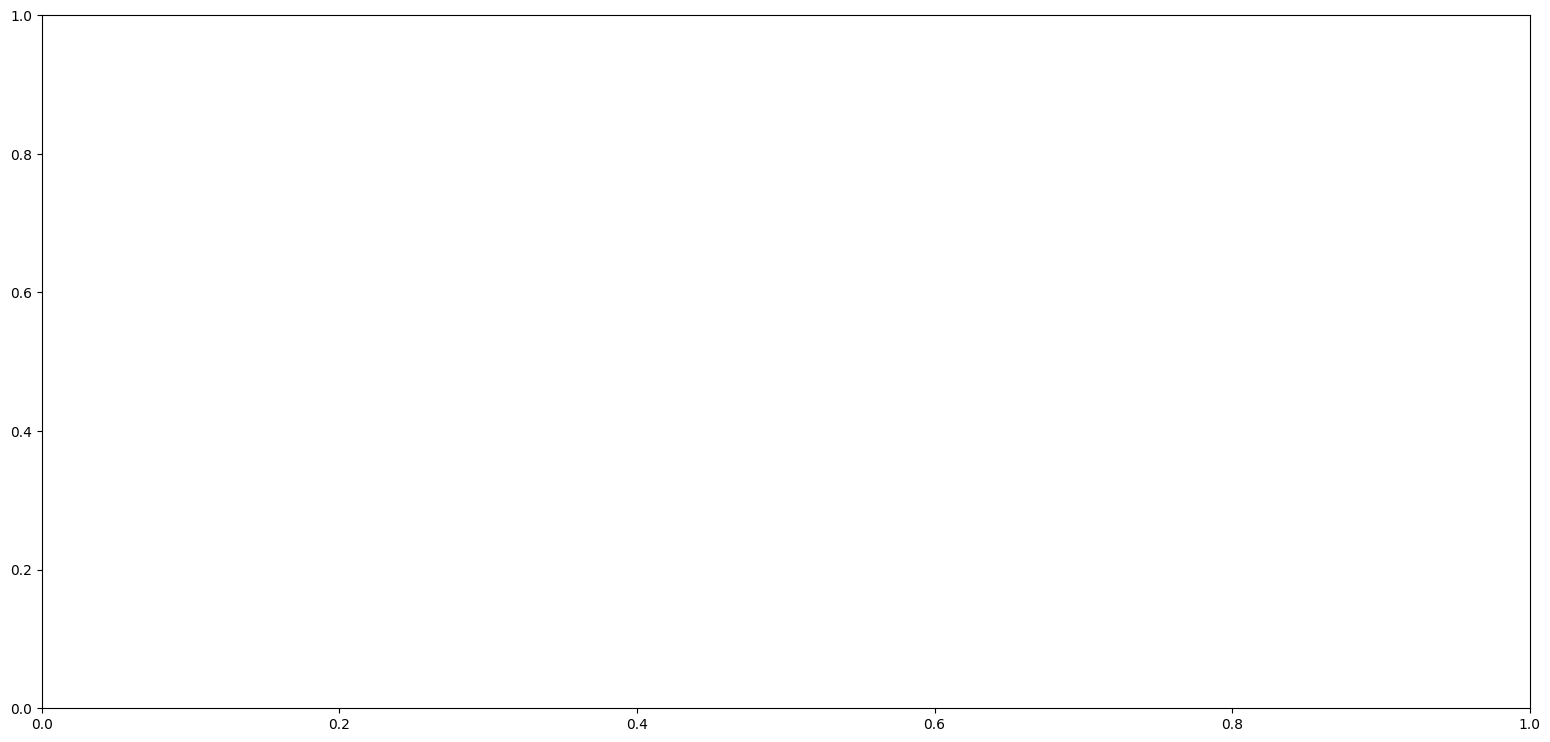

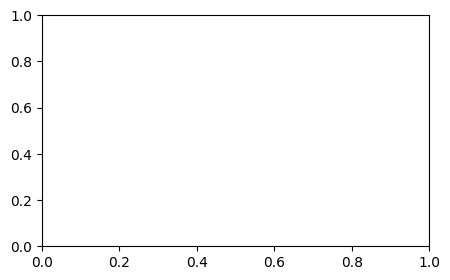

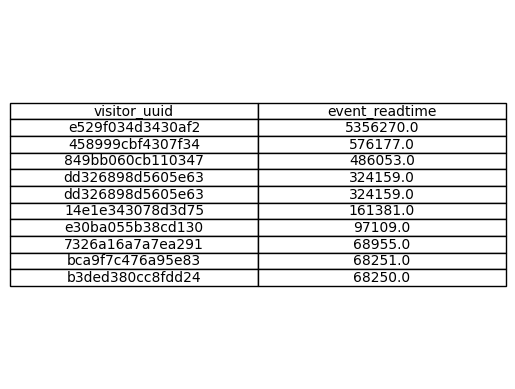

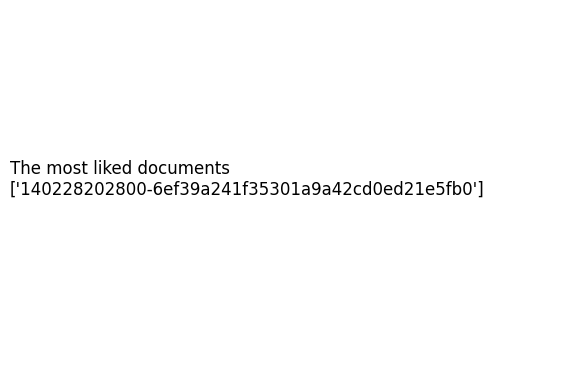

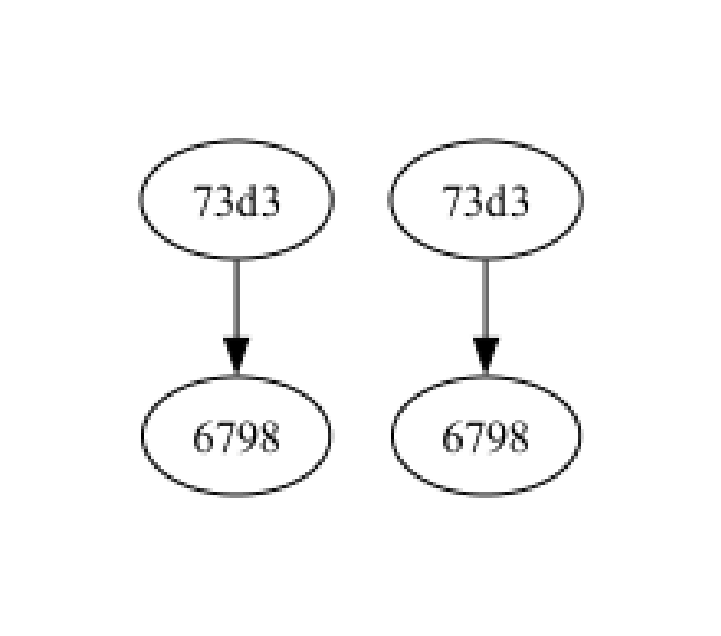

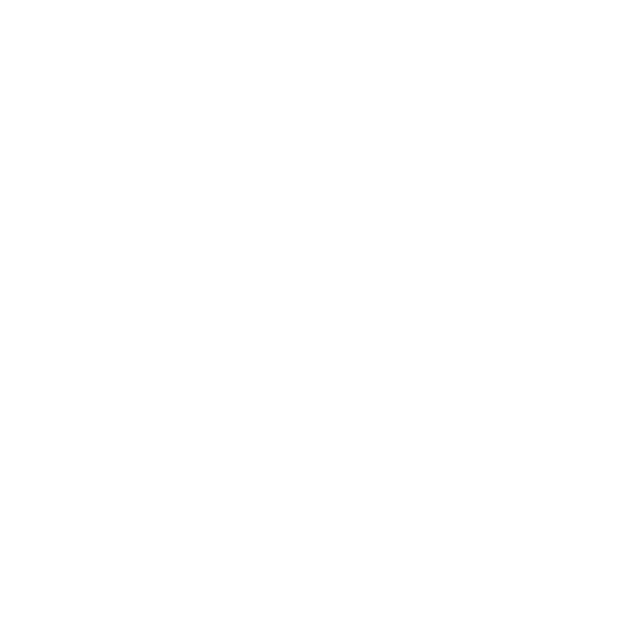

In [17]:
import tkinter as tk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageTk
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'
import fitz
import graphviz
import io
from collections import defaultdict
import tkinter.scrolledtext as st


# Import the data file
import json

dataframe= pd.read_csv("data (1).csv")

# def filename(filepath):
#     global dataframe
#     df = []
#     with open((f"./{filepath}"), "r") as file:
#         for line in file:
#             data_dict = json.loads(line)
#             df.append(data_dict)
#     dataframe = pd.DataFrame(df[0], index=[0])
#     for i in range(1, len(df)):
#         val = pd.DataFrame(df[i], index=[0])
#         dataframe = pd.concat([dataframe, val], ignore_index=True)
        

def get_visitor_uuid(doc_id):
    global dataframe
    # subject document id
    return dataframe[dataframe["subject_doc_id"] == doc_id]["visitor_uuid"]


def get_document_uuid(visitor_uuid):
    global dataframe
    return dataframe[dataframe["visitor_uuid"] == visitor_uuid]["subject_doc_id"]


root = tk.Tk()
root.title("Data Processing GUI")
frame = tk.Frame(root)
frame.pack()
canvas = None


# task 2
def plot_histogram(visitor_countries, unique_uuid):
    global dataframe
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().pack_forget()
        canvas = None
        plt.cla()

    fig = plt.figure(figsize=(20, 9))
    print(type(visitor_countries))
    colors = plt.cm.viridis(np.linspace(0, 1, unique_uuid))
    visitor_countries.value_counts().plot(kind="bar", color=colors)
    plt.title("Histogram of Visitor Countries")
    plt.xlabel("Country")
    plt.ylabel("Count")

    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


def get_visitor_country_for_doc(doc_id=None):
    global dataframe
    if doc_id is None:
        doc_id = str(entry.get())
    doc_df = dataframe[dataframe["subject_doc_id"] == doc_id]

    visitor_countries = doc_df.groupby("visitor_uuid")["visitor_country"]
    plot_histogram(visitor_countries, dataframe["visitor_uuid"].nunique())


# task 3
def view_useragent_histogram():
    global dataframe
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().pack_forget()
        canvas = None
        plt.cla()
    browser = list()
    for i in dataframe["visitor_useragent"]:
        browser.append(i.split("/")[0])
    fig = plt.figure(figsize=(5, 3))
    values, bins, bars = plt.hist(browser)
    plt.xlabel("Visitor Useragent", labelpad=20)
    plt.bar_label(bars, fontsize=8, color="red")
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


# task 4
def read_profiles():
    global dataframe
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None
        plt.cla()
    df = (
        dataframe[["visitor_uuid", "event_readtime"]]
        .sort_values(by="event_readtime", ascending=False)
        .head(10)
    )

    fig, ax = plt.subplots(1, 1)
    table_data = []
    for row in df.itertuples():
        table_data.append(row[1:])

    ax.axis("tight")
    ax.axis("off")
    ax.table(cellText=table_data, colLabels=df.columns, cellLoc="center", loc="center")
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


# task 5
def task5(doc_id=None):
    global dataframe
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None

    def also_like(doc_uuid=None, visitor_uuid=None, sorting=False):
        global dataframe
        visitor_id = get_visitor_uuid(doc_uuid)
        documents_list = []
        for i in visitor_id:
            document_id = get_document_uuid(i)
            for j in document_id:
                if j is not np.nan:
                    documents_list.append(j)
            if sorting:
                m = list(set(documents_list))
                if len(m) > 10:
                    return list(sorted(m, key=documents_list.count))[:11]
                else:
                    return list(sorted(m, key=documents_list.count))
            else:
                m = []
                for k in documents_list:
                    if k not in m:
                        m.append(k)
                if len(m) > 10:
                    return list(sorted(m, key=documents_list.count))[:11]
                else:
                    return list(sorted(m, key=documents_list.count))

    # document uuid
    if doc_id is None:
        doc_id = str(entry.get())
    val = also_like(doc_uuid=doc_id)
    fig, ax = plt.subplots(1, 1)
    ax.text(
        -0.1, 0.5, f"The most liked documents \n{val}", fontsize=12
    )  # 140228202800-6ef39a241f35301a9a42cd0ed21e5fb0

    ax.axis("off")
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()
    return

# task 6
def task6(doc_id=None):
    global dataframe
    def display_pdf_page(pdf_path, page_number):
        global dataframe
        doc = fitz.open(pdf_path)
        pix = doc.load_page(page_number).get_pixmap()
        img = Image.open(io.BytesIO(pix.tobytes()))

        # fig, ax = plt.subplots()
        fig = plt.figure(figsize=(20, 8))  # set figure size
        ax = fig.add_subplot(111)
        ax.imshow(img)
        ax.axis("off")  # to hide the axes

        return fig

    def also_like(doc_uuid=None, visitor_uuid=None, sorting=False):
        global dataframe
        document_id = get_document_uuid(visitor_uuid)
        if sorting:
            df = pd.DataFrame(document_id.value_counts())
            df.rename(columns={"subject_doc_id": "Likes"}, inplace=True)
            id_col = df.index.tolist()
            df.insert(0, "subject_doc_id", id_col, True)
            df = df.reset_index(drop=True)
            return df.sort_values(by="subject_doc_id", ascending=True).head(10)
        else:
            # print(document_id)
            df = pd.DataFrame(document_id.value_counts())
            df.rename(columns={"subject_doc_id": "Likes"}, inplace=True)
            id_col = df.index.tolist()
            df.insert(0, "subject_doc_id", id_col, True)
            df = df.reset_index(drop=True)
            return df.sort_values(by="subject_doc_id", ascending=False).head(10)

    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None
    dot = graphviz.Digraph(comment="Also likes")
    if doc_id is None:
        doc_id = str(entry.get())
    visitor_uuid = get_visitor_uuid(doc_id)  # give the document id
    d = defaultdict(list)
    node = "A"
    for i in visitor_uuid:
        df = also_like(visitor_uuid=i)["subject_doc_id"].tolist()
        parent_node = node
        dot.node(node, i[-4:])
        if len(df) == 0:
            d[str(node)] = []
            node = chr(ord(node) + 1)
        else:
            node = chr(ord(node) + 1)
            for j in df:
                if j not in d[parent_node] and j is not np.nan:
                    dot.node(str(node), j[-4:])
                    d[parent_node].append(str(node))
                    node = chr(ord(node) + 1)

    connect = list()
    for i in d.keys():
        for j in d[i]:
            connect.append(i + j)
    dot.edges(connect)
    dot.render("also-like.gv")  # store in pdf format
    pdf_path = "./also-like.gv.pdf"
    fig = display_pdf_page(pdf_path, 0)
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()


# filename("./sample_small.json")


# task-8: command line usage
def execute_command():
    global dataframe
    
    command = str(cli_entry.get())
    print(command)
    l = command.split(" ")
    task_id = int(l[l.index("-t") + 1])
    
    if task_id == 2:
        document_uuid = l[l.index("-d") + 1]
        get_visitor_country_for_doc(document_uuid)
    elif task_id == 3:
        view_useragent_histogram()
    elif task_id == 4:
        read_profiles()
    elif task_id == 5:
        document_uuid = l[l.index("-d") + 1]
        task5(document_uuid)
    elif task_id == 6:
        document_uuid = l[l.index("-d") + 1]
        task6(document_uuid)


button_frame = tk.Frame(root)
button_frame.pack(side=tk.TOP, fill=tk.X)


label1 = tk.Label(button_frame, text="Document UUID:")
label1.pack(side=tk.LEFT)
# visitor_uuid input
entry = tk.Entry(button_frame)
entry.pack(side=tk.LEFT)


tk.Button(
    button_frame,
    text="VIEW BY COUNTRY",
    command=get_visitor_country_for_doc,
    height=5,
    width=20,
).pack(padx=(100, 0), side=tk.LEFT)
tk.Button(
    button_frame,
    text="VIEW BY BROWSER",
    command=view_useragent_histogram,
    height=5,
    width=20,
).pack(side=tk.LEFT)
tk.Button(
    button_frame, text="READER PROFILES", command=read_profiles, height=5, width=20
).pack(side=tk.LEFT)
tk.Button(
    button_frame, text="ALSO LIKES FUCTIONALITY", command=task5, height=5, width=30
).pack(side=tk.LEFT)
tk.Button(
    button_frame, text="ALSO LIKES GRAPH", command=task6, height=5, width=20
).pack(side=tk.LEFT)


# Prompt label
prompt_label = tk.Label(root, text=">", fg="white", bg="black")
prompt_label.pack(side=tk.LEFT, padx=(10, 0))

# Create an entry widget for typing commands
cli_entry = tk.Entry(
    root, fg="white", bg="black", insertbackground="white"
)  # Set fg and bg colors
cli_entry.pack(side=tk.LEFT, padx=(0, 10), ipady=50, fill=tk.X, expand=True)
cli_entry.bind(
    "<Return>", lambda event: execute_command()
)  

root.mainloop()


In [41]:
def task6(doc_id=None):
    def display_pdf_page(pdf_path, page_number):
        doc = fitz.open(pdf_path)
        pix = doc.load_page(page_number).get_pixmap()
        img = Image.open(io.BytesIO(pix.tobytes()))

        # fig, ax = plt.subplots()
        fig = plt.figure(figsize=(20, 8))  # set figure size
        ax = fig.add_subplot(111)
        ax.imshow(img)
        ax.axis("off")  # to hide the axes

        return fig

    def also_like(doc_uuid=None, visitor_uuid=None, sorting=False):
        document_id = get_document_uuid(visitor_uuid)
        if sorting:
            df = pd.DataFrame(document_id.value_counts())
            df.rename(columns={"subject_doc_id": "Likes"}, inplace=True)
            id_col = df.index.tolist()
            df.insert(0, "subject_doc_id", id_col, True)
            df = df.reset_index(drop=True)
            return df.sort_values(by="subject_doc_id", ascending=True).head(10)
        else:
            # print(document_id)
            df = pd.DataFrame(document_id.value_counts())
            df.rename(columns={"subject_doc_id": "Likes"}, inplace=True)
            id_col = df.index.tolist()
            df.insert(0, "subject_doc_id", id_col, True)
            df = df.reset_index(drop=True)
            return df.sort_values(by="subject_doc_id", ascending=False).head(10)

    # global canvas
    # if canvas is not None:
    #     canvas.get_tk_widget().destroy()
    #     canvas = None
    dot = graphviz.Digraph(comment="Also likes")
    if doc_id is None:
        doc_id = str(entry.get())
    visitor_uuid = get_visitor_uuid(doc_id)  # give the document id
    d = defaultdict(list)
    node = "A"
    for i in visitor_uuid:
        df = also_like(visitor_uuid=i)["subject_doc_id"].tolist()
        parent_node = node
        dot.node(node, i[-4:])
        if len(df) == 0:
            d[str(node)] = []
            node = chr(ord(node) + 1)
        else:
            node = chr(ord(node) + 1)
            for j in df:
                if j not in d[parent_node] and j is not np.nan:
                    dot.node(str(node), j[-4:])
                    d[parent_node].append(str(node))
                    node = chr(ord(node) + 1)

    connect = list()
    for i in d.keys():
        for j in d[i]:
            connect.append(i + j)
    dot.edges(connect)
    dot.render("also-like.gv")  # store in pdf format
    # pdf_path = "./also-like.gv.pdf"
    # fig = display_pdf_page(pdf_path, 0)
    # canvas = FigureCanvasTkAgg(fig, master=root)
    # canvas.draw()
    # canvas.get_tk_widget().pack()
    
    
task6(doc_id="140224195414-e5a9acedd5eb6631bb6b3942140224195414-e5a9acedd5eb6631bb6b39422fba67982fba6798")

In [ ]:
!pip install graphviz
!pip install tk
!pip install pandas numpy pandastable PyMuPDF gdown
!gdown 1YW3_1rgEOtDFPJuSTSwivkeZRb1g4hnF

In [ ]:
import json
df = []
with open(("./sample_small.json"), 'r') as file:
    for line in file:
            data_dict = json.loads(line)
            df.append(data_dict)

In [ ]:
import pandas as pd

dataframe= pd.DataFrame(df[0],index=[0])

for i in range(1,len(df)):
  val = pd.DataFrame(df[i],index=[0])
  dataframe = pd.concat([dataframe, val], ignore_index=True)

In [ ]:
dataframe.info()

In [ ]:
def task5(doc_id=None):
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None

    def also_like(doc_uuid=None, visitor_uuid=None, sorting=False):
        visitor_id = get_visitor_uuid(doc_uuid)
        documents_list = []
        for i in visitor_id:
            document_id = get_document_uuid(i)
            for j in document_id:
                if j is not np.nan:
                    documents_list.append(j)
            if sorting:
                m = list(set(documents_list))
                if len(m) > 10:
                    return list(sorted(m, key=documents_list.count))[:11]
                else:
                    return list(sorted(m, key=documents_list.count))
            else:
                m = []
                for k in documents_list:
                    if k not in m:
                        m.append(k)
                if len(m) > 10:
                    return list(sorted(m, key=documents_list.count))[:11]
                else:
                    return list(sorted(m, key=documents_list.count))

    # document uuid
    if doc_id is None:
        doc_id = str(entry.get())
    val = also_like(doc_uuid=doc_id)
    fig, ax = plt.subplots(1, 1)
    ax.text(
        -0.1, 0.5, f"The most liked documents \n{val}", fontsize=12
    )  # 140228202800-6ef39a241f35301a9a42cd0ed21e5fb0

    ax.axis("off")
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()
    return
task5(doc_id='')

In [40]:
dataframe.head()

,ts,visitor_uuid,visitor_source,visitor_device,visitor_useragent,visitor_ip,visitor_country,visitor_referrer,env_type,env_doc_id,...,env_name,env_component,visitor_username,event_index,subject_infoboxid,subject_url,cause_position,cause_adid,env_adid,cause_embedid
0,1393631983,04daa9ed9dde73d3,external,browser,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,6a3273d508a9de04,ES,64f729926497515c,reader,140224195414-e5a9acedd5eb6631bb6b39422fba6798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1393631983,04daa9ed9dde73d3,external,browser,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,6a3273d508a9de04,ES,64f729926497515c,reader,140224195414-e5a9acedd5eb6631bb6b39422fba6798,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1393631983,ade7e1f63bc83c66,external,browser,Opera/9.80 (Windows NT 6.1) Presto/2.12.388 Ve...,b5af0ba608ab307c,BR,53c643c16e8253e7,reader,140222143932-91796b01f94327ee809bd759fd0f6c76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1393631983,ade7e1f63bc83c66,external,browser,Opera/9.80 (Windows NT 6.1) Presto/2.12.388 Ve...,b5af0ba608ab307c,BR,53c643c16e8253e7,reader,140222143932-91796b01f94327ee809bd759fd0f6c76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1393631983,232eeca785873d35,internal,browser,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,fcf9c67037f993f0,MX,63765fcd2ff864fd,stream,NaN,...,explore,editors_picks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#null values
dataframe.isnull().sum()

In [ ]:
dataframe.columns

## Task-2

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(visitor_countries, unique_uuid_country):
    colors = plt.cm.viridis(np.linspace(0, 1, unique_uuid_country))
    plt.figure(figsize=(10,5))
    visitor_countries.value_counts().plot(kind='bar', color=colors)
    plt.title('Histogram of Visitor Countries')
    plt.xlabel('Country')
    plt.ylabel('Count')
    plt.show()
    
def get_visitor_country_for_doc(doc_id):
    doc_df = dataframe[dataframe['subject_doc_id']==doc_id]
    visitor_countries = doc_df.groupby('visitor_uuid')['visitor_country']
    plot_histogram(visitor_countries,  dataframe["visitor_uuid"].nunique())
    return visitor_countries

df = get_visitor_country_for_doc(doc_id="140228202800-6ef39a241f35301a9a42cd0ed21e5fb0")

## Task-3

In [ ]:
browser=list()
for i  in dataframe['visitor_useragent']:
  browser.append(i.split("/")[0])

In [ ]:
set(browser)

In [ ]:
browser.count("Mozilla")

In [ ]:
import matplotlib.pyplot as plt
values,bins,bars=plt.hist(browser)
plt.xlabel("Visitor Useragent",labelpad=20)
plt.bar_label(bars,fontsize=8,color="red")
plt.show()

## Task-4

In [ ]:
dataframe.columns

In [ ]:
dataframe[['visitor_uuid','event_readtime']].sort_values(by='event_readtime',ascending=False).head(10)

## Task-5

In [ ]:
dataframe.columns

In [ ]:
dataframe["subject_doc_id"].value_counts().sort_values(ascending=False).head(10)

In [ ]:
def get_visitor_uuid(doc_id):
  #subject document id
  return dataframe[dataframe['subject_doc_id']==doc_id]['visitor_uuid']

def get_document_uuid(visitor_uuid):
  return dataframe[dataframe['visitor_uuid']==visitor_uuid]['subject_doc_id']


def also_like(doc_uuid=None,visitor_uuid=None,sorting=False):
  visitor_id=get_visitor_uuid(doc_uuid)
  documents_list=[]
  for i in visitor_id:
    document_id=get_document_uuid(i)
    for j in document_id:
      if j is not np.nan:
        documents_list.append(j)
    if sorting:
      m=list(set(documents_list))
      if len(m)>10:
        return list(sorted(m,key=documents_list.count))[:11]
      else:
        return list(sorted(m,key=documents_list.count))
    else:
      m=[]
      for k in documents_list:
        if k not in m:
          m.append(k)
      if len(m)>10:
        return list(sorted(m,key=documents_list.count))[:11]
      else:
        return list(sorted(m,key=documents_list.count))
print("The most liked documents")

#document uuid
val = also_like(doc_uuid="140228202800-6ef39a241f35301a9a42cd0ed21e5fb0")
val

## Task-6


In [ ]:
def get_visitor_uuid(doc_id):
  #subject document id
  return dataframe[dataframe['subject_doc_id']==doc_id]['visitor_uuid']

def get_document_uuid(visitor_uuid):
  return dataframe[dataframe['visitor_uuid']==visitor_uuid]['subject_doc_id']

def also_like(doc_uuid=None,visitor_uuid=None,sorting=False):
  document_id=get_document_uuid(visitor_uuid)
  if sorting:
    df=pd.DataFrame(document_id.value_counts())
    df.rename(columns={"subject_doc_id":"Likes"},inplace=True)
    id_col=df.index.tolist()
    df.insert(0,"subject_doc_id",id_col,True)
    df=df.reset_index(drop=True)
    return df.sort_values(by='subject_doc_id',ascending=True).head(10)
  else:
    #print(document_id)
    df=pd.DataFrame(document_id.value_counts())
    df.rename(columns={"subject_doc_id":"Likes"},inplace=True)
    id_col=df.index.tolist()
    df.insert(0,"subject_doc_id",id_col,True)
    df=df.reset_index(drop=True)
    return df.sort_values(by='subject_doc_id',ascending=False).head(10)

#uuid_visitor-04daa9ed9dde73d3
also_like(visitor_uuid="ade7e1f63bc83c66")

In [ ]:
import numpy as np
from collections import defaultdict

In [ ]:
import graphviz
dot=graphviz.Digraph(comment="Also likes")
visitor_uuid=get_visitor_uuid("140222143932-91796b01f94327ee809bd759fd0f6c76") #give the document id
d=defaultdict(list)
node='A'
for i in visitor_uuid:
  df=also_like(visitor_uuid=i)['subject_doc_id'].tolist()
  parent_node=node
  dot.node(node,i[-4:])
  if len(df)==0:
    d[str(node)]=[]
    node=chr(ord(node)+1)
  else:
    node=chr(ord(node)+1)
    for j in df:
      if j not in d[parent_node] and j is not np.nan:
        dot.node(str(node),j[-4:])
        d[parent_node].append(str(node))
        node=chr(ord(node)+1)

connect=list()
for i in  d.keys():
  for j in d[i]:
    connect.append(i+j)
print(connect)
dot.edges(connect)
print(dot.source)

In [ ]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

In [ ]:
dot.render("also-like.gv") #store in pdf format

### Task 7 GUI WITH Tkinter

In [ ]:
import tkinter as tk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image, ImageTk
import fitz
import io


root = tk.Tk()
root.title("Data Processing GUI")
frame = tk.Frame(root)
frame.pack()
canvas = None

# task 2 
def plot_histogram(visitor_countries):
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().pack_forget()
        canvas = None
        plt.cla()

    fig = plt.figure(figsize=(20,10))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_uuid_country)))
    visitor_countries.value_counts().plot(kind='bar', color=colors)
    plt.title('Histogram of Visitor Countries')
    plt.xlabel('Country')
    plt.ylabel('Count')
    
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

def get_visitor_country_for_doc():
    doc_id = str(entry.get())
    doc_df = dataframe[dataframe['subject_doc_id'] == doc_id]
    visitor_countries = doc_df.groupby('visitor_uuid')['visitor_country']
    plot_histogram(visitor_countries)

# task 3
def view_useragent_histogram():
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().pack_forget()
        canvas = None
        plt.cla()

    fig = plt.figure(figsize=(20,8))
    values, bins, bars = plt.hist(browser)
    plt.xlabel("Visitor Useragent", labelpad=20)
    plt.bar_label(bars, fontsize=8, color="red")
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# task 4
def read_profiles():
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None
        plt.cla()
    df = dataframe[['visitor_uuid','event_readtime']].sort_values(by='event_readtime',ascending=False).head(10)
    
    fig, ax = plt.subplots(1, 1)
    table_data = []
    for row in df.itertuples():
        table_data.append(row[1:])
    
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=table_data, colLabels=df.columns, cellLoc = 'center', loc='center')
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()
    


# task 5 
def task5():
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None
    doc_id = str(entry.get())
    val = also_like(doc_uuid=doc_id)
    fig, ax = plt.subplots(1, 1)
    ax.text(-0.1, 0.5, f"The most liked documents \n{val}", fontsize=12) # 140228202800-6ef39a241f35301a9a42cd0ed21e5fb0
    
    ax.axis('off')
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()
    return

# task 6 
def display_pdf_page(pdf_path, page_number):
    doc = fitz.open(pdf_path)
    pix = doc.load_page(page_number).get_pixmap()
    img = Image.open(io.BytesIO(pix.tobytes()))

    # fig, ax = plt.subplots()
    fig = plt.figure(figsize=(20,8))  # set figure size
    ax = fig.add_subplot(111)
    ax.imshow(img)
    ax.axis('off')  # to hide the axes

    return fig

def task6():
    global canvas
    if canvas is not None:
        canvas.get_tk_widget().destroy()
        canvas = None
    pdf_files = [f for f in os.listdir("./") if f.endswith('.pdf')]
    pdf_path = f"./{pdf_files[0]}"
    fig = display_pdf_page(pdf_path, 0)
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack()




button_frame = tk.Frame(root)
button_frame.pack(side=tk.TOP, fill=tk.X)

entry = tk.Entry(button_frame)
entry.pack(side=tk.LEFT)

tk.Button(button_frame, text="VIEW BY COUNTRY", command=get_visitor_country_for_doc, height=5, width=30).pack(side=tk.LEFT)
tk.Button(button_frame, text="VIEW BY BROWSER", command=view_useragent_histogram, height=5, width=30).pack(side=tk.LEFT)
tk.Button(button_frame, text="READER PROFILES", command=read_profiles, height=5, width=30).pack(side=tk.LEFT)
tk.Button(button_frame, text="ALSO LIKES FUCTIONALITY", command=task5, height=5, width=30).pack(side=tk.LEFT)
tk.Button(button_frame, text="ALSO LIKES GRAPH", command=task6, height=5, width=30).pack(side=tk.LEFT)
root.mainloop()


In [ ]:
import os
pdf_files = [f for f in os.listdir("./") if f.endswith('.pdf')]
pdf_files[0]